# Sonifications of WISE Infared Images

## Imports

In [64]:
# Python standard library
import os
import urllib

# Other third-party software
import numpy as np
from skimage.measure import block_reduce
import matplotlib.pyplot as plt

# Audio
#from audiolazy import str2midi # Apparently doesnt work in Python >3.6
from midiutil import MIDIFile

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

from astropy.visualization import make_lupton_rgb

from astroquery.skyview import SkyView

from astropy.io import fits
from astropy.utils.data import download_file

# Astroquery
import astroquery
from astroquery.simbad import Simbad
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

# Possible Targets

1. **Andromeda (M31) Galaxy** (using all four infrared detectors)
    - RA: 00h 42m 44s
    - Dec: +41° 16' 09"
2. IC 342 - a normally obscured galaxy visible through infrared imaging
    - RA: 03h 46m 48s
    - Dec: +68° 05' 46"
3. WISE 0458+6434 - which is thought to consist of two T-class brown dwarfs
    - RA: 04h 58m 48s
    - Dec: +64° 34' 52"
4. The runaway star Zeta Ophiuchi and the bow shock formed by this massive star
    - RA: 16h 37m 09s
    - Dec: -10° 34' 01"
5. Puppis A, which is a supernova remnant
    - RA: 08h 24m 08s
    - Dec: -42° 59' 26"
6. The Rho Ophiuchi cloud complex
    - RA: - RA 16h 28m 6s
    - Dec -24° 32′ 30″
7. Lambda Centauri nebula (IC 2944), a star-forming region in the Milky Way
    - RA: 11h 36m 36.0s
    - Dec: −63° 02′ 00″
8. WISE data used to trace the Milky Way's spiral arms
9. X-shape of the Milky Way bulge revealed by WISE
10. WISE J224607.57-052635.0, the most luminous known galaxy in the Universe.
    - RA: 22h 46m 07.57s
    - Dec: -05° 26' 35.0"

# Data Acquisition

In [2]:
def fetch_wise_images(targets, output_root_directory, bands=['WISE 3.4', 'WISE 4.6', 'WISE 12', 'WISE 22']):
    """
    Fetches WISE survey images in FITS format for a list of targets and organizes them into separate folders.

    Parameters:
        targets (list of tuple): List of tuples, each containing the target name (str) and its coordinates (astropy.coordinates.SkyCoord).
        output_root_directory (str): Root directory where the downloaded FITS files and subfolders will be saved.
        bands (list of str): List of survey bands to fetch (e.g., ['WISE 3.4', 'WISE 4.6']).

    Returns:
        Dictionary containing target names as keys and lists of downloaded FITS file paths as values.
    """
    downloaded_files_by_target = {}
    
    # Create the output root directory if it doesn't exist
    if not os.path.exists(output_root_directory):
        os.makedirs(output_root_directory)

    for target_name, target_coordinates in targets:
        # Create a subdirectory for the target
        target_directory = os.path.join(output_root_directory, target_name)

        # Create the target's subdirectory if it doesn't exist
        if not os.path.exists(target_directory):
            os.makedirs(target_directory)

        # Fetch images from SkyView
        img_list = SkyView.get_images(position=target_coordinates, survey=bands)

        # Download and save the images for the target
        downloaded_files = []
        for i, img_info in enumerate(img_list):
            # Open header
            header = img_info[0].header
            
            # Extract coordinates from the header
            ra = header['CRVAL1']
            dec = header['CRVAL2']
            
            # Get the band from the list of bands and remove decimals
            band = bands[i].replace('WISE ', '').replace(' ', '').replace('.', '')
            
            # Convert coordinates to a suitable format for the file name
            ra_str = str(ra).replace('.', '').replace('-', '').replace(' ', '').zfill(8)
            dec_str = str(dec).replace('.', '').replace('-', '').replace(' ', '').zfill(7)
            
            # Construct the file name with coordinates
            filename = os.path.join(target_directory, f'WISE_J{ra_str}_{dec_str}_{band}.fits')
            #filename = os.path.join(target_directory, f'{survey_name}_{ra_str}_{dec_str}_{bands[i]}.fits')
            img_info[0].writeto(filename, overwrite=True)
            downloaded_files.append(filename)

        downloaded_files_by_target[target_name] = downloaded_files

    return downloaded_files_by_target

In [3]:
# List of targets with names and coordinates
targets = [
    ('M31', coord.SkyCoord.from_name('M31', frame='icrs')),
    ('IC 342', coord.SkyCoord.from_name('IC 342', frame='icrs'))
]

# Root directory where the downloaded FITS files and subfolders will be saved
root_output_dir = 'wise_images'

# Fetch WISE images for each target and organize them into subdirectories
downloaded_files_by_target = fetch_wise_images(targets, root_output_dir)

# Print the list of downloaded files for each target
for target_name, downloaded_files in downloaded_files_by_target.items():
    print(f"Downloaded FITS files for {target_name}:")
    for filename in downloaded_files:
        print(filename)

Downloaded FITS files for M31:
wise_images\M31\WISE_J00106847_0412688_34.fits
wise_images\M31\WISE_J00106847_0412688_46.fits
wise_images\M31\WISE_J00106847_0412688_12.fits
wise_images\M31\WISE_J00106847_0412688_22.fits
Downloaded FITS files for IC 342:
wise_images\IC 342\WISE_J00567022_0680961_34.fits
wise_images\IC 342\WISE_J00567022_0680961_46.fits
wise_images\IC 342\WISE_J00567022_0680961_12.fits
wise_images\IC 342\WISE_J00567022_0680961_22.fits


In [4]:
def open_fits_file(file_path):
    ''' Open FITS image file
    '''
    with fits.open(file_path) as hdu_list:
        data = hdu_list[0].data
    return data

In [5]:
def file_path_joiner(file_name, root_path):
    ''' Get file path of images to open
    '''
    relative_path = root_path + file_name
    file_path = os.path.join(os.getcwd(), relative_path)
    return file_path

In [6]:
relative_path = 'wise_images/M31/WISE_J00106847_0412688_12.fits'
image_file_path = os.path.join(os.getcwd(), relative_path)
#image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

In [7]:
image_file_path1 = file_path_joiner('WISE_J00106847_0412688_12.fits', 'wise_images/M31/')
image_file_path2 = file_path_joiner('WISE_J00106847_0412688_22.fits', 'wise_images/M31/')
image_file_path3 = file_path_joiner('WISE_J00106847_0412688_34.fits', 'wise_images/M31/')
image_file_path4 = file_path_joiner('WISE_J00106847_0412688_46.fits', 'wise_images/M31/')

In [10]:
image_data1 = open_fits_file(image_file_path1)#.astype(np.float64)
image_data2 = open_fits_file(image_file_path2)#.astype(np.float64)
image_data3 = open_fits_file(image_file_path3)#.astype(np.float64)
image_data4 = open_fits_file(image_file_path4)#.astype(np.float64)

In [11]:
print(image_data1.dtype, image_data2.dtype, image_data3.dtype, image_data4.dtype)
print(image_data1.shape, image_data2.shape, image_data3.shape, image_data4.shape)

print(np.min(image_data1), np.max(image_data1))
print(np.min(image_data2), np.max(image_data2))
print(np.min(image_data3), np.max(image_data3))
print(np.min(image_data4), np.max(image_data4))

>f4 >f4 >f4 >f4
(300, 300) (300, 300) (300, 300) (300, 300)
422.43933 971.7129
122.00838 133.15477
63.78296 3752.8735
32.889618 1491.2661


In [18]:
red_image = image_data4.astype(np.float32)
green_image = image_data3.astype(np.float32)
blue_image = image_data1.astype(np.float32)

In [13]:
red_image = np.clip(image_data4, 0, 1)
green_image = np.clip(image_data3, 0, 1)
blue_image = np.clip(image_data1, 0, 1)

In [17]:
print(red_image.dtype, green_image.dtype, blue_image.dtype)
print(red_image.shape, green_image.shape, blue_image.shape)

print(np.min(red_image), np.max(red_image))
print(np.min(green_image), np.max(green_image))
print(np.min(blue_image), np.max(blue_image))

float32 float32 float32
(300, 300) (300, 300) (300, 300)
1.0 1.0
1.0 1.0
1.0 1.0


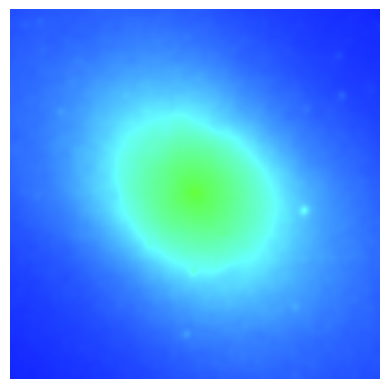

In [19]:
image = make_lupton_rgb(red_image, green_image, blue_image)
plt.axis('off')
plt.imshow(image, origin='lower')

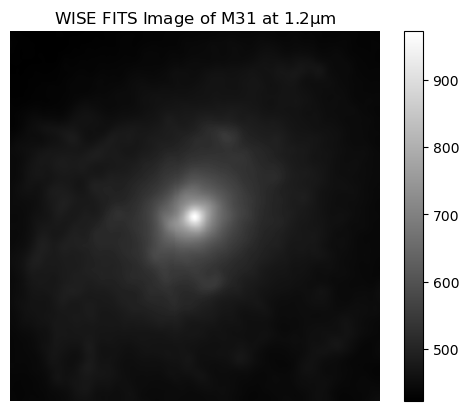

In [94]:
# Open the FITS file
hdu_list = fits.open(image_file_path1)

data = hdu_list[0].data

# Display image
plt.imshow(data, cmap='gray') #viridis
plt.colorbar()
plt.title(r'WISE FITS Image of M31 at 1.2$\rm \mu m$')
plt.axis("off")
plt.show()

hdu_list.close()

# Sonificiation Algorithm

In [20]:
def normalize_image_data(image_data):
    ''' Normalize the image data between 0 and 1.0
    '''
    return(image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data))

In [21]:
def calculate_midi_pitch_range(octave_offset):
    """
    Calculate the MIDI pitch range based on the given octave offset.
    
    Parameters:
        octave_offset (int): The octave offset value (e.g., 0 for the default octave).
    
    Returns:
        tuple: A tuple containing the minimum and maximum MIDI pitches for the specified octave.
    """
    # Define the number of semitones in an octave
    semitones_per_octave = 12

    # Calculate the MIDI pitch for the minimum note of the specified octave
    min_pitch = octave_offset * semitones_per_octave

    # Calculate the MIDI pitch for the maximum note of the specified octave
    max_pitch = min_pitch + semitones_per_octave - 1

    return min_pitch, max_pitch

In [55]:
def map_brightness_to_pitch_and_velocity(brightness, min_pitch = 60, max_pitch = 72):
    ''' Define a mapping function for brightness to pitch and velocity
    '''
    # Define the range for mapping brightness to pitch (e.g., from C4 to C6)
    pitch_range = [min_pitch, max_pitch]  # MIDI note numbers

    # Map brightness to pitch within the defined range
    pitch = int(np.interp(brightness, [0, 1], pitch_range))

    # Map brightness to velocity (e.g., linear mapping)
    velocity = int(np.interp(brightness, [0, 1], [40, 127]))

    return pitch, velocity

In [90]:
def create_image_sonification(normalized_data, output_file, bpm = 60):
    '''
    '''
    
    # Assumes all images are same size
    num_rows, num_cols = normalized_data[0].shape
    
    #duration_beats = 52.8 # desired duration in beats (1 beat = 1 second if bpm=60)
    bpm = 120 # Tempo in beats per minute (BPM)
    duration_per_pixel = 1 #0.1
    
    time_grid = np.arange(0, normalized_data[0].size)
    #print(time_grid)
    #print(normalized_data[0].size, len(normalized_data))
    
    # Define the sampling rate (e.g., every 10th pixel)
    sampling_rate = 10

    #y_scale = 0.5  #scaling parameter for y-axis data (1 = linear)

    # Note set for mapping (or use a few octaves of a specific scale)
    #note_names = ['C1','C2','G2',
    #             'C3','E3','G3','A3','B3',
    #             'D4','E4','G4','A4','B4',
    #             'D5','E5','G5','A5','B5',
    #             'D6','E6','F#6','G6','A6']
    
    #note_names = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
    
    #vel_min, vel_max = 35, 127   # define minimum and maximum note velocity
    
    # Define octave offsets for each frequency band
    #octave_offsets = [0, 12, 24, 36]
    min_pitch = 60
    max_pitch = 72
    #octave_offsets = [i for i in range(0, len(normalized_data))]
    octave_offsets = [i - 1 for i in range(0, len(normalized_data))]
    print(f"Octave offsets: {octave_offsets}")
    
    ## Calculate duration in seconds
    #duration_sec = max(t_data)*60/bpm # duration in seconds (actually, onset of last note)
    
    # Create a MIDI file
    midi_file = MIDIFile(1)
    midi_file.addTempo(0, 0, bpm)
    
    print("Creating MIDI file...")
    
    ## Map image data to MIDI notes and velocity
    for band_index, img_data in enumerate(normalized_data):
        
        # reset time grid
        time_point = 0
        
        # Compute midi pitch range
        min_pitch, max_pitch = calculate_midi_pitch_range(octave_offsets[band_index])
        #print(f"min pitch:{min_pitch}, max pitch:{max_pitch}")

        for i in range(0, num_rows):
            for j in range(0, num_cols):
                
                # Get pixel value
                brightness = img_data[i, j]

                # Map brightness value to note names and octave
                #note_name, octave = map_pixel_to_note_name_and_octave(brightness, octave_offsets[band_index])
                #note_name, octave = map_pixel_to_note_name_and_octave(pixel_value_band1, octave_offsets[band_index])
                
                
                
                # Map brightness to pitch and velocity
                pitch, velocity = map_brightness_to_pitch_and_velocity(
                    brightness, min_pitch, max_pitch
                )

                # Convert note names to midi pitch
                #pitch = str2midi(f"{note_name}{octave}")

                # Velocity
                #velocity = int(127 * pixel_value)
                #velocity = scale_midi_velocity(int(127 * pixel_value), vel_min, vel_max)
                #velolcity_mapped = scale_midi_velocity(velocity, min_velocity, max_velocity)

                # Layer the notes from different bands together at the same time point
                #time_point = j
                
                #print(f"time_point:{time_point}, pitch:{pitch}, velocity:{velocity}")

                midi_file.addNote(
                    0,  # Track number
                    0,  # Channel number
                    pitch,
                    time_point,
                    int(duration_per_pixel), # note duration
                    velocity
                )
                
                time_point += 1
                #print(f"time_point:{time_point}, pitch:{pitch}, velocity:{velocity}")
    
    # Save the MIDI file
    with open(output_file, "wb") as file:
        midi_file.writeFile(file)
    
    print(f"Saved: {output_file}")

In [81]:
# File paths
image_file_path1 = file_path_joiner('WISE_J00106847_0412688_12.fits', 'wise_images/M31/')
image_file_path2 = file_path_joiner('WISE_J00106847_0412688_22.fits', 'wise_images/M31/')
image_file_path3 = file_path_joiner('WISE_J00106847_0412688_34.fits', 'wise_images/M31/')
image_file_path4 = file_path_joiner('WISE_J00106847_0412688_46.fits', 'wise_images/M31/')

image_data1 = open_fits_file(image_file_path1)
image_data2 = open_fits_file(image_file_path2)
image_data3 = open_fits_file(image_file_path3)
image_data4 = open_fits_file(image_file_path4)

In [82]:
kernel_size = (10,10)

image_data1 = block_reduce(image_data1, block_size=kernel_size, func=np.mean, cval=np.mean(image_data1))
image_data2 = block_reduce(image_data2, block_size=kernel_size, func=np.mean, cval=np.mean(image_data2))
image_data3 = block_reduce(image_data3, block_size=kernel_size, func=np.mean, cval=np.mean(image_data3))
image_data4 = block_reduce(image_data4, block_size=kernel_size, func=np.mean, cval=np.mean(image_data4))

In [83]:
# normalize the image pixel values between 0 and 1.0
normalized_data = [normalize_image_data(image_data1), 
                   normalize_image_data(image_data2), 
                   normalize_image_data(image_data3), 
                   normalize_image_data(image_data4)]

In [84]:
# define output file name
output_file = "WISE_J00106847_0412688_ver2.midi"

In [91]:
# Create the MIDI sonification
create_image_sonification(normalized_data, output_file, bpm = 60)

Octave offsets: [0, 1, 2, 3]
Creating MIDI file...
Saved: WISE_J00106847_0412688.midi


In [ ]:
def create_image_sonification(normalized_data, output_file, bpm = 60):
    '''
    '''
    
    # Assumes all images are same size
    num_rows, num_cols = normalized_data[0].shape
    
    #duration_beats = 52.8 # desired duration in beats (1 beat = 1 second if bpm=60)
    bpm = 60 # Tempo in beats per minute (BPM)
    duration_per_pixel = 0.1
    
    time_grid = np.arange(0, normalized_data[0].size)
    #print(time_grid)
    #print(normalized_data[0].size, len(normalized_data))
    
    # Define the sampling rate (e.g., every 10th pixel)
    sampling_rate = 10

    #y_scale = 0.5  #scaling parameter for y-axis data (1 = linear)

    # Note set for mapping (or use a few octaves of a specific scale)
    #note_names = ['C1','C2','G2',
    #             'C3','E3','G3','A3','B3',
    #             'D4','E4','G4','A4','B4',
    #             'D5','E5','G5','A5','B5',
    #             'D6','E6','F#6','G6','A6']
    
    #note_names = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']
    
    #vel_min, vel_max = 35, 127   # define minimum and maximum note velocity
    
    # Define octave offsets for each frequency band
    #octave_offsets = [0, 12, 24, 36]
    min_pitch = 60
    max_pitch = 72
    octave_offsets = [i for i in range(0, len(normalized_data))]
    print(f"Octave offsets: {octave_offsets}")
    
    ## Calculate duration in seconds
    #duration_sec = max(t_data)*60/bpm # duration in seconds (actually, onset of last note)
    
    # Create a MIDI file
    midi_file = MIDIFile(1)
    midi_file.addTempo(0, 0, bpm)
    
    print("Creating MIDI file...")
    
    ## Map image data to MIDI notes and velocity
    for band_index, img_data in enumerate(normalized_data):
        
        # reset time grid
        #time_point = 0
        
        # Compute midi pitch range
        min_pitch, max_pitch = calculate_midi_pitch_range(octave_offsets[band_index])
        print(f"min pitch:{min_pitch}, max pitch:{max_pitch}")

        for i in range(0, num_rows):
            for j in range(0, num_cols):
                
                # Get pixel value
                brightness = img_data[i, j]

                # Map brightness value to note names and octave
                #note_name, octave = map_pixel_to_note_name_and_octave(brightness, octave_offsets[band_index])
                #note_name, octave = map_pixel_to_note_name_and_octave(pixel_value_band1, octave_offsets[band_index])
                
                
                
                # Map brightness to pitch and velocity
                pitch, velocity = map_brightness_to_pitch_and_velocity(
                    brightness, min_pitch, max_pitch
                )

                # Convert note names to midi pitch
                #pitch = str2midi(f"{note_name}{octave}")

                # Velocity
                #velocity = int(127 * pixel_value)
                #velocity = scale_midi_velocity(int(127 * pixel_value), vel_min, vel_max)
                #velolcity_mapped = scale_midi_velocity(velocity, min_velocity, max_velocity)

                # Layer the notes from different bands together at the same time point
                time_point = j
                
                print(f"time_point:{time_point}, pitch:{pitch}, velocity:{velocity}")

                midi_file.addNote(
                    0,  # Track number
                    0,  # Channel number
                    pitch,
                    time_point,
                    int(duration_per_pixel), # note duration
                    velocity
                )
                
                #time_point += 1
                #print(f"time_point:{time_point}, pitch:{pitch}, velocity:{velocity}")
            
    # Save the MIDI file
    with open(output_file, "wb") as file:
        midi_file.writeFile(file)
    
    print(f"Saved: {output_file}")